In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from core import med_log_odds_cutoff, bw_color_palette
from textwrap import fill
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve

In [3]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6

In [4]:
def select_domains(hhblits_df, prob_cutoff=50):
    # Other Domains
    out_list = []
    for group, group_df in tqdm(hhblits_df[(hhblits_df['Prob'] > prob_cutoff)].groupby('query'), 
                                position=0, total=hhblits_df['query'].nunique()):
        group_df = group_df.sort_values('Prob', ascending=False)
        while len(group_df):
            selected_row = group_df.head(1).squeeze()
            out_list.append(selected_row)
            group_df = group_df[(group_df['qend'] < selected_row['qstart']) |
                                (group_df['qstart'] > selected_row['qend'])]
    selected_domain_df = pd.concat(out_list, axis=1).T
    return selected_domain_df

In [5]:
qcov = 0.4

In [6]:
def assign_hit_category(row, qcov=qcov):
    if row['defense_system_protein']:
        return 'Defense homolog in expected system'
    elif row['defense_homolog']:
        return 'Defense homolog in new context'
    elif (row['q_cov'] > qcov):
        return 'Remote defense homolog'
    else:
        return 'Predicted novel defense gene'

In [7]:
predictions = pd.read_csv('../data3/interim/ecor_predictions.csv')
hhpred_results = pd.read_csv('../data3/interim/ecor_putative_novel_pfam_df_domains.csv')
pfam_clans = pd.read_table('../data/raw/Pfam-A.clans.tsv', 
                           names=['pfam_id', 'clan_id', 'clan_name', 'pfam_name', 'pfam_description'])

/state/partition1/slurm_tmp/2109735.0.0/ipykernel_1441898/2325829114.py:1: DtypeWarning: Columns (24,30) have mixed types. Specify dtype option on import or set low_memory=False.
  predictions = pd.read_csv('../data3/interim/ecor_predictions.csv')


In [8]:
blacklisted_domains = pd.read_csv('../data3/interim/df_blacklisted_domains.csv')

In [9]:
total_pred = len(predictions)
print('Total # genes', total_pred)
g_p5 = (predictions['mean_log_odds'] > 0).sum()
print('# Genes with P > 0.5', g_p5)
print('Frac genes with P > 0.5', round(g_p5/total_pred, 3))
g_cutoff = (predictions['mean_log_odds'] > med_log_odds_cutoff).sum()
print('# genes with LO >', round(med_log_odds_cutoff, 3), g_cutoff)
print('frac. genes with LO >', round(med_log_odds_cutoff, 3), round(g_cutoff/total_pred, 3))


Total # genes 321347
# Genes with P > 0.5 4279
Frac genes with P > 0.5 0.013
# genes with LO > 4 1991
frac. genes with LO > 4 0.006


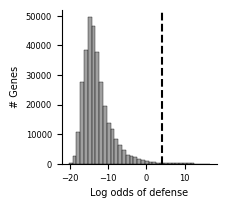

In [10]:
plt.subplots(figsize=(2,2))
sns.histplot(predictions['mean_log_odds'], binwidth=1, 
             color='grey')
plt.xlabel('Log odds of defense')
plt.ylabel('# Genes')
plt.axvline(x=med_log_odds_cutoff, linestyle='dashed', color='black')
sns.despine()
plt.savefig('../figures/hit_distribution.svg', dpi=300, bbox_inches='tight')

In [11]:
filtered_predictions = predictions[predictions['mean_log_odds'] > med_log_odds_cutoff].copy()
filtered_predictions['accession_stub'] = (filtered_predictions['product_accession']
                                          .str.split('.', expand=True)[0])

In [12]:
hhpred_results['q_ali_len'] = hhpred_results['qend'] - hhpred_results['qstart']


In [13]:
remote_defense_homologs = (hhpred_results[hhpred_results['hit_name'].str.contains('~') &
                                          (hhpred_results['Prob'] > 50)]
                           .sort_values('q_ali_len', ascending=False)
                           .groupby('query')
                           .head(1)
                           .merge(filtered_predictions[['product_accession', 'product_length']].drop_duplicates(), 
                                  how='left', left_on='query', right_on='product_accession'))
remote_defense_homologs['q_cov'] = remote_defense_homologs['q_ali_len']/remote_defense_homologs['product_length']


In [14]:
merged_predictions = (filtered_predictions.merge(
    remote_defense_homologs[['product_accession', 'hit_name', 'q_cov', 'Prob']], how='left', 
                                                   on='product_accession'))
merged_predictions['q_cov'] = merged_predictions['q_cov'].fillna(0)
merged_predictions['hit_category'] = merged_predictions.apply(assign_hit_category, axis=1)
hit_categories = ['Defense homolog in expected system',
                  'Defense homolog in new context', 
                  'Remote defense homolog', 
                  'Predicted novel defense gene']
merged_predictions['hit_category'] = pd.Categorical(merged_predictions['hit_category'], 
                                                    categories=hit_categories)

In [15]:
merged_predictions['hit_category'].value_counts()/len(merged_predictions)

hit_category
Defense homolog in new context        0.506781
Predicted novel defense gene          0.272225
Defense homolog in expected system    0.132597
Remote defense homolog                0.088398
Name: count, dtype: float64

In [16]:
merged_predictions['hit_category'].value_counts()

hit_category
Defense homolog in new context        1009
Predicted novel defense gene           542
Defense homolog in expected system     264
Remote defense homolog                 176
Name: count, dtype: int64

In [17]:
(merged_predictions['hit_category'] != 'Defense homolog in expected system').sum()

1727

In [18]:
predictions['defense_system_protein'].sum()

395

In [19]:
predictions.loc[(predictions['mean_log_odds'] <= med_log_odds_cutoff) & 
            (predictions['defense_system_protein']), 'defense_homolog_names'].value_counts()

defense_homolog_names
RM_Type_IV__Type_IV_REases                                                                                                                  34
Mok_Hok_Sok__Hok                                                                                                                            22
ShosTA__ShosA, PsyrTA__PsyrA                                                                                                                 8
Shango__SngC, PsyrTA__PsyrT                                                                                                                  8
PD-T4-1__PD-T4-1                                                                                                                             6
Gabija__GajB_3, Gabija__GajB_2, Gabija__GajB_1                                                                                               4
PD-T4-3__PD-T4-3                                                                                                        

In [20]:
merged_predictions.loc[merged_predictions['hit_category'] == 'Defense homolog in new context', 
                       'defense_homolog_names'].value_counts().head(60)

defense_homolog_names
RM__Type_I_S                                                                                                                                                                                     63
RM_Type_II__Type_II_MTases, RM__Type_I_MTases, PrrC__EcoprrI                                                                                                                                     58
Retron_I_B__ATPase_TOPRIM_COG3593, PARIS_I__AAA_15                                                                                                                                               56
RM__Type_I_REases                                                                                                                                                                                55
RM_Type_II__Type_II_REases                                                                                                                                                                       4

In [21]:
novel_cov_abundance = (merged_predictions[merged_predictions['hit_category'] == 'Predicted novel defense gene']
                       .groupby('q_cov')
                       .agg(n_proteins=('product_accession', 'count'))
                       .reset_index()
                       .sort_values('q_cov'))
novel_cov_abundance['tot_n_proteins'] = novel_cov_abundance['n_proteins'].cumsum()

In [22]:
novel_pred_df = (merged_predictions[merged_predictions['hit_category'] == 'Predicted novel defense gene']
                 .sort_values('q_cov', ascending=True)
                 .reset_index(drop=True))
novel_pred_df['present'] = 1
novel_pred_df['n_proteins'] = novel_pred_df['present'].cumsum()

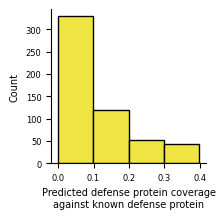

In [23]:
plt.subplots(figsize=(2,2))
sns.histplot(data=merged_predictions[merged_predictions['hit_category'] == 'Predicted novel defense gene'], 
             x='q_cov', binwidth=0.1, color='#f0e442', alpha=1)
plt.xlabel('Predicted defense protein coverage\nagainst known defense protein')
sns.despine()
plt.savefig('../figures/novel_coverage.svg', dpi=300, bbox_inches='tight')

In [24]:
(novel_pred_df['q_cov'] == 0).sum()

274

In [25]:
((novel_pred_df['q_cov'] > 0) & (novel_pred_df['q_cov'] < 0.4)).sum()

268

In [26]:
(novel_pred_df['q_cov'] <= 0.1).sum()

397

In [27]:
(novel_pred_df['q_cov'] == 0).sum()

274

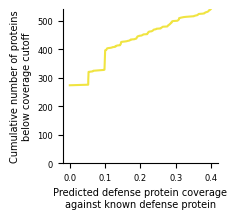

In [28]:
plt.subplots(figsize=(2,2))
sns.lineplot(data=novel_cov_abundance,
             x='q_cov', y='tot_n_proteins', color='#f0e442', alpha=1)
plt.xlabel('Predicted defense protein coverage\nagainst known defense protein')
plt.ylabel('Cumulative number of proteins\nbelow coverage cutoff')
sns.despine()
plt.ylim(0, len(novel_pred_df))
plt.savefig('../figures/novel_coverage_cumsum.svg', dpi=300, bbox_inches='tight')

In [29]:
no_defense_homology_df = merged_predictions.loc[~merged_predictions['defense_homolog'] & 
                                                 (merged_predictions['q_cov'] == 0),:]
no_defense_homology_df.to_csv('../data3/interim/predicted_defense_no_homology_df.csv', index=False)

In [30]:
len(no_defense_homology_df)

274

In [31]:
no_defense_homology_df['cluster_id'].nunique()

118

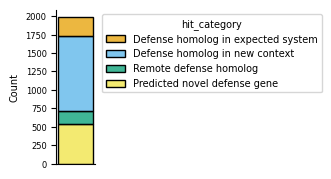

In [32]:
_, ax = plt.subplots(figsize=(0.5, 2))
ax = sns.histplot(data=merged_predictions, x=0, 
             hue='hit_category', 
             multiple='stack', 
             palette=bw_color_palette[:4], ax=ax, )
sns.move_legend(ax, bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()
plt.xticks([])
plt.xlabel('')
plt.savefig('../figures/predicted_defense_known_frac.svg', dpi=300, bbox_inches='tight')

In [33]:
missing_dsp = predictions[predictions['defense_system_protein'] & 
                           ~predictions['protein_context_id'].isin(merged_predictions['protein_context_id'])].copy()
missing_dsp['hit_category'] = 'Defense homolog in expected system'
cat_merged_predictions = pd.concat([missing_dsp, merged_predictions])
hit_category_map = {cat: fill(cat, 20) for cat in hit_categories}
cat_merged_predictions['display_category'] = cat_merged_predictions['hit_category'].map(hit_category_map)
display_cat_order = list(hit_category_map.values())
cat_merged_predictions['display_category'] = pd.Categorical(cat_merged_predictions['display_category'], 
                                                            categories=display_cat_order)

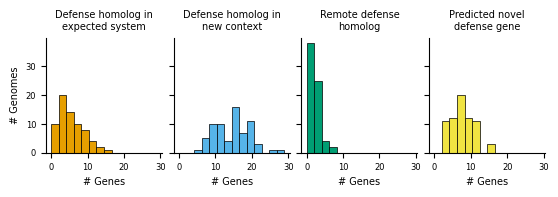

In [34]:
dp_per_genome = (cat_merged_predictions.groupby(['assembly', 'display_category'])
                 .agg(n_proteins=('product_accession', 'count'))
                 .reset_index())
g = sns.displot(data=dp_per_genome, x='n_proteins', binwidth=2, 
                hue='display_category', palette=(bw_color_palette[:4]), 
                col='display_category', kind='hist', facet_kws={'sharey': True}, 
                alpha=1, height=2, legend=False, aspect=0.7)
g.set_titles(template='{col_name}')
g.set_xlabels('# Genes')
g.set_ylabels('# Genomes')
g.figure.subplots_adjust(wspace=0.1)
plt.savefig('../figures/dp_per_genome.svg', bbox_inches='tight', dpi=300)

In [35]:
novel_accessions = merged_predictions.loc[merged_predictions['hit_category'] == 'Predicted novel defense gene', 
                                          'product_accession'].drop_duplicates()
n_partial_align = remote_defense_homologs['product_accession'].isin(novel_accessions).sum()
print('# predicted novel defense genes with partial alignment:', n_partial_align)
print('Frac with partial alignment', n_partial_align/len(novel_accessions))

# predicted novel defense genes with partial alignment: 135
Frac with partial alignment 0.4179566563467492


In [36]:
pfam_results = hhpred_results[(hhpred_results['hit_name'].str[:2] == 'PF') & 
                              (hhpred_results['Prob'] > 50)].copy()
pfam_results['pfam_id'] = pfam_results['hit_name'].str.split('.', expand=True)[0]
pfam_results = pfam_results.merge(pfam_clans, how='left', on='pfam_id')

In [37]:
novel_pfam_results = pfam_results[pfam_results['query'].isin(novel_accessions)]
novel_pfam_clans = (novel_pfam_results[['query', 'clan_name']]
                    .drop_duplicates())

In [38]:
select_novel_pfam_domains = select_domains(novel_pfam_results)

100%|██████████| 262/262 [00:00<00:00, 669.97it/s]


In [39]:
select_novel_pfam_known_domains = select_novel_pfam_domains[select_novel_pfam_domains['pfam_id'].isin(blacklisted_domains['pfam_id'])]

In [40]:
novel_genes_known_domains = merged_predictions.loc[(merged_predictions['hit_category'] == 'Predicted novel defense gene') & 
                                                   (merged_predictions['product_accession'].isin(select_novel_pfam_known_domains['query']))]

In [41]:
len(novel_genes_known_domains)

325

In [42]:
(select_novel_pfam_domains[['query','pfam_name', 'clan_name']].drop_duplicates()
 [['pfam_name', 'clan_name']]
 .value_counts()
 .head(20))

pfam_name        clan_name    
RepB-RCR_reg     Met_repress      21
IIGP             P-loop_NTPase    14
Dynamin_N        P-loop_NTPase    14
Mrr_cat_2        PDDEXK            6
DpnII-MboI       PDDEXK            6
KicB             HTH               5
NinG             His-Me_finger     5
NurA             RNase_H           3
HEPN_Apea        KNTase_C          3
Herpes_ori_bp    P-loop_NTPase     3
Nucleoporin_FG2  FG_rpt            3
PDDEXK_4         PDDEXK            3
LAX              TRAP              3
DUF1887          PDDEXK            3
BrxC_BrxD        P-loop_NTPase     3
Polbeta          NTP_transf        3
Response_reg_2   CheY              3
pEK499_p136      KNTase_C          3
ATPase_2         P-loop_NTPase     3
HATPase_c_5      His_Kinase_A      3
Name: count, dtype: int64

In [43]:
novel_pfam_clan_count = (select_novel_pfam_domains.groupby('clan_name')
                         .agg(count=('query', 'nunique'))
                         .rename(index={'P-loop_NTPase': 'P-loop NTPase', 
                                        'PDDEXK': 'PDDEXK nuclease', 
                                        'PEP-carboxyk': 'PEP carboxykinase',
                                        'Met_repress': 'RHH antitoxin DNA binding', 
                                        'KNTase_C': 'HEPN', 
                                        'His-Me_finger': 'HNH endonuclease', 
                                        'Zn_Beta_Ribbon': 'Zinc finger', 
                                        'His_Kinase_A': 'His kinase phospho-acceptor'})
                         .sort_values('count', ascending=False)
                         .reset_index())
novel_pfam_clan_count['freq'] = novel_pfam_clan_count['count']/len(novel_accessions)

In [44]:
novel_pfam_clan_count

,clan_name,count,freq
0,PDDEXK nuclease,28,0.086687
1,P-loop NTPase,24,0.074303
2,RHH antitoxin DNA binding,21,0.065015
3,HEPN,12,0.037152
4,HTH,7,0.021672
5,PIN,6,0.018576
6,HNH endonuclease,6,0.018576
7,His kinase phospho-acceptor,4,0.012384
8,TRAP,3,0.009288
9,RNase_H,3,0.009288


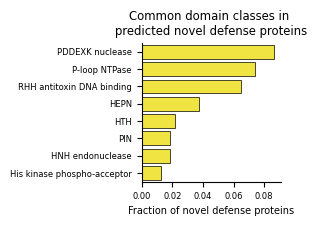

In [45]:
plt.subplots(figsize=(1.8,1.8))
sns.barplot(data=novel_pfam_clan_count.head(8), y='clan_name', x='freq', 
            color=bw_color_palette[3], linewidth=0.5, edgecolor='black', saturation=100)
sns.despine()
plt.xlabel('Fraction of novel defense proteins')
plt.ylabel('')
plt.title('Common domain classes in \npredicted novel defense proteins')
plt.savefig('../figures/predicted_novel_defense_domains.svg', dpi=300, bbox_inches='tight')

In [46]:
def assign_hit_category2(row, cutoff=med_log_odds_cutoff, qcov=qcov):
    if row['defense_system_protein']:
        return 'Defense homolog in expected system'
    elif row['mean_log_odds'] > cutoff:
        if row['defense_homolog']:
            return 'Defense homolog in new context'
        elif (row['q_cov'] > qcov):
            return 'Remote defense homolog'
        else: 
            return 'Predicted novel defense gene'
    else:
        return 'Not defensive'

In [47]:
merged_predictions['hit_category'].value_counts()

hit_category
Defense homolog in new context        1009
Predicted novel defense gene           542
Defense homolog in expected system     264
Remote defense homolog                 176
Name: count, dtype: int64

In [50]:
all_merged_predictions = (predictions.merge(
    merged_predictions[['protein_context_id', 'hit_name', 'q_cov', 'Prob']], how='left', 
                                                   on='protein_context_id'))
all_merged_predictions['q_cov'] = all_merged_predictions['q_cov'].fillna(0)

all_merged_predictions['hit_category'] = all_merged_predictions.apply(assign_hit_category2, axis=1)
hit_categories = ['Defense homolog in expected system',
                  'Defense homolog in new context', 
                  'Remote defense homolog', 
                  'Predicted novel defense gene', 
                  'Not defensive']
all_merged_predictions['hit_category'] = pd.Categorical(all_merged_predictions['hit_category'], 
                                                    categories=hit_categories)


In [51]:
all_merged_predictions.to_csv('../data3/interim/ecor_predictions_defensive_cat.csv', index=False)


In [52]:
all_merged_predictions['hit_category'].value_counts()

hit_category
Not defensive                         319225
Defense homolog in new context          1009
Predicted novel defense gene             542
Defense homolog in expected system       395
Remote defense homolog                   176
Name: count, dtype: int64

In [84]:
len(novel_accessions)

323

In [94]:
pd.DataFrame(novel_accessions).to_csv('../data3/interim/ecor_pred_def_seq_novel.txt', index=False, header=False)

In [96]:
!conda run -n beaker seqtk subseq ../data/interim/ecor_unique_seqs.faa ../data3/interim/ecor_pred_def_seq_novel.txt > ../data3/interim/ecor_pred_def_seq_novel.faa


### Redo these analyses, but only consider one gene per cluster

In [53]:
non_redundant_predictions = (all_merged_predictions
                             .sort_values(['hit_category', 'mean_log_odds'], ascending=[True, False])
                             .groupby('cluster_id')
                             .head(1))

In [54]:
non_redundant_predictions['hit_category'].value_counts()

hit_category
Not defensive                         10590
Defense homolog in new context          219
Predicted novel defense gene            190
Defense homolog in expected system      152
Remote defense homolog                  103
Name: count, dtype: int64

In [53]:
len(non_redundant_predictions)

11254

In [54]:
(non_redundant_predictions['mean_log_odds'] > 0).sum()

1085

In [55]:
total_pred = len(non_redundant_predictions)
print('Total # genes', total_pred)
g_p5 = (non_redundant_predictions['mean_log_odds'] > 0).sum()
print('# Genes with P > 0.5', g_p5)
print('Frac genes with P > 0.5', round(g_p5/total_pred, 3))
g_cutoff = (non_redundant_predictions['mean_log_odds'] > med_log_odds_cutoff).sum()
print('# genes with LO >', round(med_log_odds_cutoff, 3), g_cutoff)
print('frac. genes with LO >', round(med_log_odds_cutoff, 3), round(g_cutoff/total_pred, 3))


Total # genes 11254
# Genes with P > 0.5 1085
Frac genes with P > 0.5 0.096
# genes with LO > 4 624
frac. genes with LO > 4 0.055


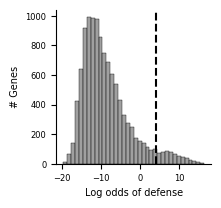

In [56]:
plt.subplots(figsize=(2,2))
sns.histplot(non_redundant_predictions['mean_log_odds'], binwidth=1, 
             color='grey')
plt.xlabel('Log odds of defense')
plt.ylabel('# Genes')
plt.axvline(x=med_log_odds_cutoff, linestyle='dashed', color='black')
sns.despine()
plt.savefig('../figures/hit_distribution_nr.svg', dpi=300, bbox_inches='tight')

In [57]:
filtered_nr_predictions = non_redundant_predictions[non_redundant_predictions['mean_log_odds'] > med_log_odds_cutoff].copy()
filtered_nr_predictions['accession_stub'] = (filtered_nr_predictions['product_accession']
                                          .str.split('.', expand=True)[0])
filtered_nr_predictions['hit_category'] = filtered_nr_predictions['hit_category'].cat.remove_unused_categories()

In [58]:
filtered_nr_predictions['hit_category'].value_counts()/len(filtered_nr_predictions)

hit_category
Defense homolog in new context        0.350962
Predicted novel defense gene          0.304487
Defense homolog in expected system    0.179487
Remote defense homolog                0.165064
Name: count, dtype: float64

In [59]:
filtered_nr_predictions['hit_category'].value_counts()

hit_category
Defense homolog in new context        219
Predicted novel defense gene          190
Defense homolog in expected system    112
Remote defense homolog                103
Name: count, dtype: int64

In [60]:
non_redundant_predictions['defense_system_protein'].sum()

152

In [61]:
non_redundant_predictions.loc[(non_redundant_predictions['mean_log_odds'] <= med_log_odds_cutoff) & 
            (non_redundant_predictions['defense_system_protein']), 'defense_homolog_names'].value_counts()

defense_homolog_names
RM_Type_IV__Type_IV_REases                                                                                                                  3
CBASS__Phospholipase                                                                                                                        2
CBASS__AG_E1_ThiF, CBASS__AG_E2_Prok-E2_B                                                                                                   2
Shango__SngC, PsyrTA__PsyrT                                                                                                                 2
dCTPdeaminase__dCTPdeaminase                                                                                                                2
CBASS__Jab                                                                                                                                  1
BREX__brxHII, DISARM_1__drmD                                                                                                  

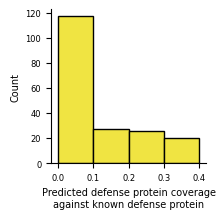

In [62]:
plt.subplots(figsize=(2,2))
sns.histplot(data=filtered_nr_predictions[filtered_nr_predictions['hit_category'] == 'Predicted novel defense gene'], 
             x='q_cov', binwidth=0.1, color='#f0e442', alpha=1)
plt.xlabel('Predicted defense protein coverage\nagainst known defense protein')
sns.despine()
#plt.savefig('../figures/novel_coverage.svg', dpi=300, bbox_inches='tight')

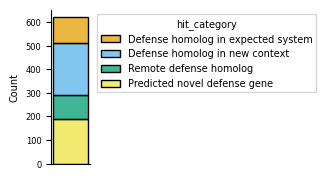

In [63]:
_, ax = plt.subplots(figsize=(0.5, 2))
ax = sns.histplot(data=filtered_nr_predictions, x=0, 
             hue='hit_category', 
             multiple='stack', 
             palette=bw_color_palette[:4], ax=ax, )
sns.move_legend(ax, bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()
plt.xticks([])
plt.xlabel('')
plt.savefig('../figures/predicted_defense_known_frac_nr.svg', dpi=300, bbox_inches='tight')

In [64]:
nr_novel_accessions = filtered_nr_predictions.loc[filtered_nr_predictions['hit_category'] == 'Predicted novel defense gene', 
                                          'product_accession'].drop_duplicates()
nr_novel_pfam_results = pfam_results[pfam_results['query'].isin(nr_novel_accessions)]
nr_novel_pfam_clans = (nr_novel_pfam_results[['query', 'clan_name']]
                    .drop_duplicates())

In [65]:
nr_select_novel_pfam_domains = select_domains(nr_novel_pfam_results)

100%|██████████| 139/139 [00:00<00:00, 560.11it/s]


In [66]:
(nr_select_novel_pfam_domains[['query','pfam_name', 'clan_name']].drop_duplicates()
 [['pfam_name', 'clan_name']]
 .value_counts()
 .head(20))

pfam_name        clan_name    
RepB-RCR_reg     Met_repress      7
NinG             His-Me_finger    5
HATPase_c_5      His_Kinase_A     3
DpnII-MboI       PDDEXK           3
IIGP             P-loop_NTPase    3
Response_reg_2   CheY             3
Dynamin_N        P-loop_NTPase    3
KicB             HTH              2
ATP-synt_B       ATP_synthase     2
PDDEXK_4         PDDEXK           2
PIN              PIN              2
HEPN_Apea        KNTase_C         2
Metallophos_3    Calcineurin      2
AAA_35           P-loop_NTPase    2
Polbeta          NTP_transf       2
Mrr_cat_2        PDDEXK           2
Phage_holin_2_3  Holin-II         1
Phage_holin_2_1  Holin-II         1
NERD             PDDEXK           1
pP_pnuc_2        SPOCS            1
Name: count, dtype: int64

In [67]:
nr_novel_pfam_clan_count = (nr_select_novel_pfam_domains.groupby('clan_name')
                         .agg(count=('query', 'nunique'))
                         .rename(index={'P-loop_NTPase': 'P-loop NTPase', 
                                        'PDDEXK': 'PDDEXK nuclease', 
                                        'PEP-carboxyk': 'PEP carboxykinase',
                                        'Met_repress': 'RHH antitoxin DNA binding', 
                                        'KNTase_C': 'HEPN', 
                                        'His-Me_finger': 'HNH endonuclease', 
                                        'Zn_Beta_Ribbon': 'Zinc finger', 
                                        'His_Kinase_A': 'His kinase phospho-acceptor', 
                                        'CheY': 'Response regulator'})
                         .sort_values('count', ascending=False)
                         .reset_index())
nr_novel_pfam_clan_count['freq'] = nr_novel_pfam_clan_count['count']/len(nr_novel_accessions)

In [68]:
from matplotlib.ticker import FuncFormatter

In [69]:
def to_percent_no_sign(x, pos):
    return f"{100 * x:.0f}"

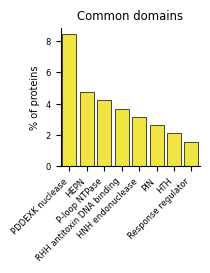

In [70]:
plt.subplots(figsize=(1.8,1.8))
sns.barplot(data=nr_novel_pfam_clan_count.head(8), x='clan_name', y='freq', 
            color=bw_color_palette[3], linewidth=0.5, edgecolor='black', saturation=100)
sns.despine()
plt.xticks(rotation=45, ha='right')
plt.ylabel('% of proteins')
plt.xlabel('')
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent_no_sign))
plt.title('Common domains')
plt.savefig('../figures/predicted_novel_defense_domains_nr.svg', dpi=300, bbox_inches='tight')

In [71]:
nr_novel_pfam_clan_count.head(8)

,clan_name,count,freq
0,PDDEXK nuclease,16,0.084211
1,HEPN,9,0.047368
2,P-loop NTPase,8,0.042105
3,RHH antitoxin DNA binding,7,0.036842
4,HNH endonuclease,6,0.031579
5,PIN,5,0.026316
6,HTH,4,0.021053
7,Response regulator,3,0.015789


In [72]:
novel_cluster_known_domains_n = nr_select_novel_pfam_domains.loc[nr_select_novel_pfam_domains['pfam_id']
                                 .isin(blacklisted_domains['pfam_id']), 'query'].nunique()

In [73]:
novel_cluster_known_domains_n

90

In [74]:
len(nr_novel_accessions)

190

In [75]:
novel_cluster_known_domains_n/len(nr_novel_accessions)

0.47368421052631576

In [76]:
cluster_n_genomes = (predictions.groupby('cluster_id')
                     .agg(n_genomes=('assembly', 'nunique'))
                     .reset_index())
predicted_novel_defense_clusters = merged_predictions.loc[merged_predictions['hit_category'] == 'Predicted novel defense gene', 
                                                          ['cluster_id']].drop_duplicates()
pnd_clusters_n_genomes = (predicted_novel_defense_clusters.merge(cluster_n_genomes, 
                                                                how='inner', on='cluster_id'))
pnd_clusters_n_genomes['category'] = 'Predicted novel\ndefense genes'
known_defense_clusters = predictions.loc[predictions['defense_system_protein'], 
                                         ['cluster_id']].drop_duplicates()
kd_clusters_n_genomes = (known_defense_clusters.merge(cluster_n_genomes, 
                                                      how='inner', on='cluster_id'))
kd_clusters_n_genomes['category'] = 'All defense homologs\nin expected systems'
cluster_n_genomes['category'] = 'All genes'
cluster_categories_n_genomes = pd.concat([cluster_n_genomes, pnd_clusters_n_genomes, kd_clusters_n_genomes], axis=0)
cluster_categories_n_genomes['category'] = pd.Categorical(cluster_categories_n_genomes['category'], 
                                                              categories=['All genes',
                                                                  'All defense homologs\nin expected systems',
                                                                'Predicted novel\ndefense genes'])

In [77]:
cluster_n_genomes = (predictions.groupby('cluster_id')
                     .agg(n_genomes=('assembly', 'nunique'))
                     .reset_index())
cluster_n_genomes['category'] = 'All protein clusters'
novel_clusters = non_redundant_predictions.loc[non_redundant_predictions["hit_category"] == 'Predicted novel defense gene', 
                                               'cluster_id']
novel_n_genomes = cluster_n_genomes[cluster_n_genomes['cluster_id'].isin(novel_clusters)].copy()
novel_n_genomes['category'] = 'Predicted novel defense'
known_clusters = non_redundant_predictions.loc[non_redundant_predictions["hit_category"] == 'Defense homolog in expected system', 
                                               'cluster_id']
known_n_genomes = cluster_n_genomes[cluster_n_genomes['cluster_id'].isin(known_clusters)].copy()
known_n_genomes['category'] = 'Defense homologs in expected system'
cluster_categories_n_genomes = pd.concat([cluster_n_genomes, novel_n_genomes, known_n_genomes], axis=0)
cluster_categories_n_genomes['category'] = pd.Categorical(cluster_categories_n_genomes['category'], 
                                                              categories=['All protein clusters',
                                                                  'Defense homologs in expected system',
                                                                'Predicted novel defense'])

In [78]:
cluster_categories_n_genomes['accessory_gene'] = cluster_categories_n_genomes['n_genomes'] <= 5

In [79]:
(cluster_categories_n_genomes.groupby('category')
 .agg(frac_accessory=('accessory_gene', lambda x: x.sum()/len(x))))

,frac_accessory
category,
All protein clusters,0.521237
Defense homologs in expected system,0.697368
Predicted novel defense,0.884211


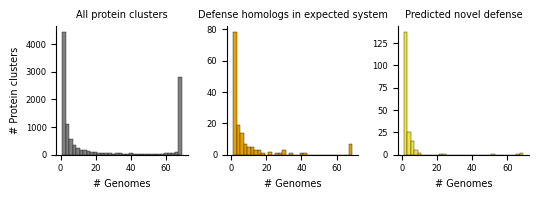

In [80]:
g = sns.displot(data=cluster_categories_n_genomes, x='n_genomes', binwidth=2, 
                hue='category', palette=(['grey', '#e69f00', '#f0e442']), 
                col='category', kind='hist', facet_kws={'sharey': False}, 
                alpha=1, height=2, legend=False, aspect=0.9)
g.set_titles(template='{col_name}')
g.set_xlabels('# Genomes')
g.set_ylabels('# Protein clusters')
g.figure.subplots_adjust(wspace=0.3)
plt.savefig('../figures/cluster_distribution.svg', dpi=300, bbox_inches='tight')

In [81]:
nr_select_novel_pfam_domains.to_csv('../data3/interim/ecor_unique_novel_pfam_domains.csv', index=False)

In [82]:
nr_novel_predictions = non_redundant_predictions[non_redundant_predictions['hit_category'] == 'Predicted novel defense gene']

In [83]:
nr_novel_predictions.to_csv('../data3/interim/ecor_unique_novel_proteins.csv', index=False)